# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Thu May 25 12:37:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0               43W /  N/A|   4662MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9453
Epoch 1: val_accuracy improved from -inf to 0.58411, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 71s 171ms/step - loss: 0.3060 - accuracy: 0.9453 - val_loss: 2.6675 - val_accuracy: 0.5841 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9731
Epoch 2: val_accuracy improved from 0.58411 to 0.82466, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 61s 166ms/step - loss: 0.0928 - accuracy: 0.9731 - val_loss: 0.7056 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9797
Epoch 3: val_accuracy did not improve from 0.82466
367/367 [==============================] - 43s 117ms/step - loss: 0.0751 - accuracy: 0.9797 - val_loss: 1.9299 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9840
Epoch 4: val_accuracy improved from 0.82466 to 0.96603, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 60s 165ms/step - loss: 0.0557 - accuracy: 0.9840 - val_loss: 0.1229 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9864
Epoch 5: val_accuracy did not improve from 0.96603
367/367 [==============================] - 43s 116ms/step - loss: 0.0443 - accuracy: 0.9864 - val_loss: 1.5931 - val_accuracy: 0.5841 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9913
Epoch 6: val_accuracy did not improve from 0.96603
367/367 [==============================] - 42s 115ms/step - loss: 0.0325 - accuracy: 0.9913 - val_loss: 0.3501 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9879
Epoch 7: val_accuracy did not improve from 0.96603
367/367 [==============================] - 41s 113ms/step - loss: 0.0488 - accuracy: 0.9879 - val_loss: 0.2714 - va

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 80s 217ms/step - loss: 0.0188 - accuracy: 0.9958 - val_loss: 0.0340 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9962
Epoch 11: val_accuracy improved from 0.99233 to 0.99671, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 62s 169ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0132 - val_accuracy: 0.9967 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975
Epoch 12: val_accuracy improved from 0.99671 to 0.99726, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 105s 285ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0089 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9985
Epoch 13: val_accuracy improved from 0.99726 to 0.99836, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 62s 168ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0059 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9985
Epoch 14: val_accuracy did not improve from 0.99836
367/367 [==============================] - 44s 119ms/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 0.0092 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989
Epoch 15: val_accuracy did not improve from 0.99836
367/367 [==============================] - 45s 121ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0071 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9990
Epoch 16: val_accuracy did not improve from 0.99836
367/367 [==============================] - 45s 123ms/step - loss: 0.0037 - accuracy: 0.9990 - val

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 66s 180ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 19/100
367/367 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995
Epoch 19: val_accuracy improved from 0.99890 to 0.99945, saving model to Grape_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Non_Augmented\assets


367/367 [==============================] - 67s 181ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 20/100
367/367 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993
Epoch 20: val_accuracy did not improve from 0.99945
367/367 [==============================] - 46s 125ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0011 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 21/100
367/367 [==============================] - ETA: 0s - loss: 3.4100e-04 - accuracy: 1.0000
Epoch 21: val_accuracy did not improve from 0.99945
367/367 [==============================] - 46s 124ms/step - loss: 3.4100e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 22/100
367/367 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9995
Epoch 22: val_accuracy did not improve from 0.99945
367/367 [==============================] - 45s 123ms/step - loss: 0.0013 - accuracy: 0.99

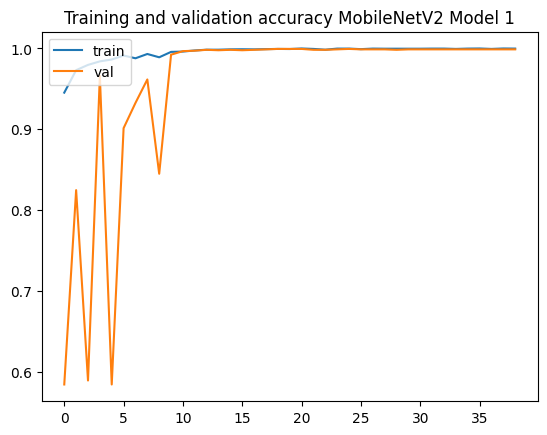

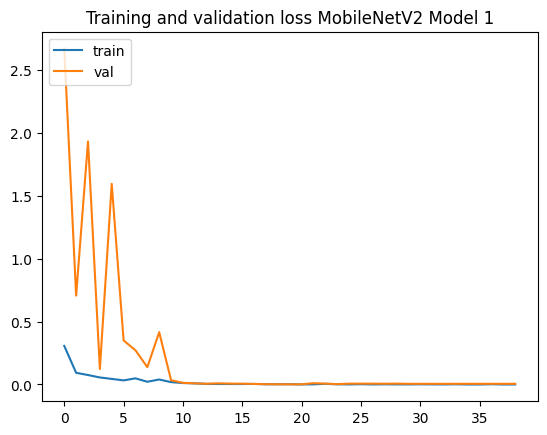

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
MobileNetV2_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9543
Epoch 1: val_accuracy improved from -inf to 0.24932, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 68s 173ms/step - loss: 0.1606 - accuracy: 0.9543 - val_loss: 25.9693 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9756
Epoch 2: val_accuracy improved from 0.24932 to 0.71945, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 60s 164ms/step - loss: 0.0798 - accuracy: 0.9756 - val_loss: 1.7190 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9796
Epoch 3: val_accuracy did not improve from 0.71945
367/367 [==============================] - 42s 114ms/step - loss: 0.0704 - accuracy: 0.9796 - val_loss: 28.0997 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9845
Epoch 4: val_accuracy did not improve from 0.71945
367/367 [==============================] - 43s 117ms/step - loss: 0.0555 - accuracy: 0.9845 - val_loss: 3.8436 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9894
Epoch 5: val_accuracy improved from 0.71945 to 0.93151, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 64s 175ms/step - loss: 0.0416 - accuracy: 0.9894 - val_loss: 0.2300 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9888
Epoch 6: val_accuracy did not improve from 0.93151
367/367 [==============================] - 43s 118ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 13.4660 - val_accuracy: 0.3003 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9853
Epoch 7: val_accuracy did not improve from 0.93151
367/367 [==============================] - 44s 119ms/step - loss: 0.0611 - accuracy: 0.9853 - val_loss: 3.1332 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9899
Epoch 8: val_accuracy did not improve from 0.93151
367/367 [==============================] - 44s 120ms/step - loss: 0.0392 - accuracy: 0.9899 - val_loss: 0.2715 - v

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
367/367 [==============================] - 62s 168ms/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.3957 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9967
Epoch 11: val_accuracy improved from 0.93863 to 0.99507, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 63s 172ms/step - loss: 0.0156 - accuracy: 0.9967 - val_loss: 0.0138 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9978
Epoch 12: val_accuracy improved from 0.99507 to 0.99781, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 61s 166ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0055 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9977
Epoch 13: val_accuracy improved from 0.99781 to 0.99890, saving model to Grape_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Non_Augmented\assets


367/367 [==============================] - 62s 169ms/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 0.0051 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9985
Epoch 14: val_accuracy did not improve from 0.99890
367/367 [==============================] - 43s 116ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0030 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9989
Epoch 15: val_accuracy did not improve from 0.99890
367/367 [==============================] - 43s 117ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0047 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9989
Epoch 16: val_accuracy did not improve from 0.99890
367/367 [==============================] - 43s 118ms/step - loss: 0.0054 - accuracy: 0.9989 - val

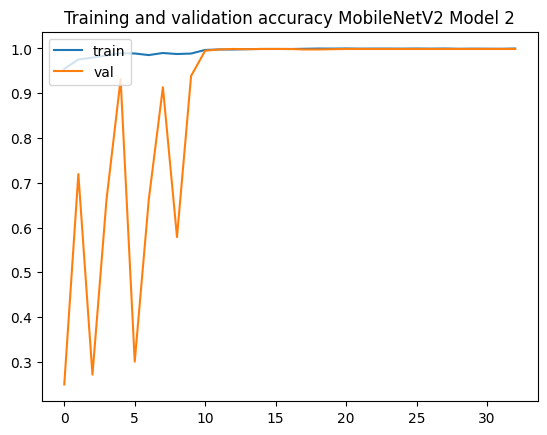

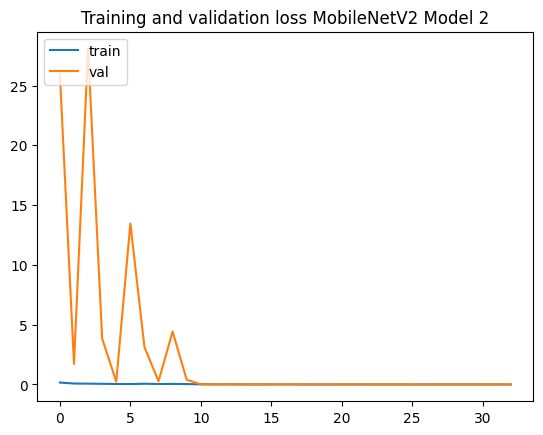

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')